In [2]:
import anndata as ad
import scanpy as sc
import pickle
import numpy as np
import pandas as pd
from collections import defaultdict

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%run -i 0_functions.py

# Data

In [5]:
id_name = {}
counter = 0
division = 5
for i in [1, 2, 3]:
    for j in range(division):
        id_name[counter] = {"rep": i, "subset": j, "cell_type": "mono"}
        counter += 1

for i in [1, 2, 3]:
    for j in range(division):
        id_name[counter] = {"rep": i, "subset": j, "cell_type": "ery"}
        counter += 1

In [6]:
id_name

{0: {'rep': 1, 'subset': 0, 'cell_type': 'mono'},
 1: {'rep': 1, 'subset': 1, 'cell_type': 'mono'},
 2: {'rep': 1, 'subset': 2, 'cell_type': 'mono'},
 3: {'rep': 1, 'subset': 3, 'cell_type': 'mono'},
 4: {'rep': 1, 'subset': 4, 'cell_type': 'mono'},
 5: {'rep': 2, 'subset': 0, 'cell_type': 'mono'},
 6: {'rep': 2, 'subset': 1, 'cell_type': 'mono'},
 7: {'rep': 2, 'subset': 2, 'cell_type': 'mono'},
 8: {'rep': 2, 'subset': 3, 'cell_type': 'mono'},
 9: {'rep': 2, 'subset': 4, 'cell_type': 'mono'},
 10: {'rep': 3, 'subset': 0, 'cell_type': 'mono'},
 11: {'rep': 3, 'subset': 1, 'cell_type': 'mono'},
 12: {'rep': 3, 'subset': 2, 'cell_type': 'mono'},
 13: {'rep': 3, 'subset': 3, 'cell_type': 'mono'},
 14: {'rep': 3, 'subset': 4, 'cell_type': 'mono'},
 15: {'rep': 1, 'subset': 0, 'cell_type': 'ery'},
 16: {'rep': 1, 'subset': 1, 'cell_type': 'ery'},
 17: {'rep': 1, 'subset': 2, 'cell_type': 'ery'},
 18: {'rep': 1, 'subset': 3, 'cell_type': 'ery'},
 19: {'rep': 1, 'subset': 4, 'cell_type': 'er

In [7]:
# pathx must be the path that represents the x values of the path. 
#       it also indexes datasetx, so they must be the same length or less
# pathy must be the path that represents the y values of the path.
#       it also indexes datasety, so they must be the same length or less
def avg_cost_path(pathx, pathy, matrix, datasetx, datasety):
    sorted_names1 = datasetx.obs["pseudotime"].sort_values().index
    sorted_names2 = datasety.obs["pseudotime"].sort_values().index
    print(max(pathx), max(pathy), len(sorted_names1), len(sorted_names2), matrix.shape)

    assert(max(pathx)) <= len(sorted_names1), (f"pathx (max val {max(pathx)}) contains indices that are out of bounds for datasetx (length {len(sorted_names1)})")
    assert(max(pathy)) <=  len(sorted_names2), (f"pathy (max val {max(pathy)}) contains indices that are out of bounds for datasety (length {len(sorted_names2)})")

    # check that at least one of the paths goes to the end of the matrix
    # assert(max(pathx) == len(sorted_names1) - 1 or max(pathy) == len(sorted_names2) - 1), f"at least one of the paths must go to the end of the matrix. path x goes to {max(pathx)} and path y goes to {max(pathy)}, but datasetx has {len(sorted_names1)} cells and datasety has {len(sorted_names2)} cells."

    avg_costx = defaultdict(list)
    avg_costy = defaultdict(list)

    for x, y in zip(pathx, pathy):
        # print(x, y, sorted_names1[x], sorted_names2[y])
        if x <= matrix.shape[1] and y <= matrix.shape[0]:
            cost = matrix[y-1, x-1]

            avg_costx[sorted_names1[x-1]].append(cost)
            avg_costy[sorted_names2[y-1]].append(cost)

    acx = [sum(x) / len(x) for x in avg_costx.values()]
    acy = [sum(x) / len(x) for x in avg_costy.values()]

    costx = pd.Series(acx, index=list(avg_costx.keys()))
    costy = pd.Series(acy, index=list(avg_costy.keys()))

    return costx, costy

In [8]:
results = pickle.load(open("data/results_no_dup_hvg_2.pkl", "rb"))

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7386672972f0>>
Traceback (most recent call last):
  File "/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


1063 1063


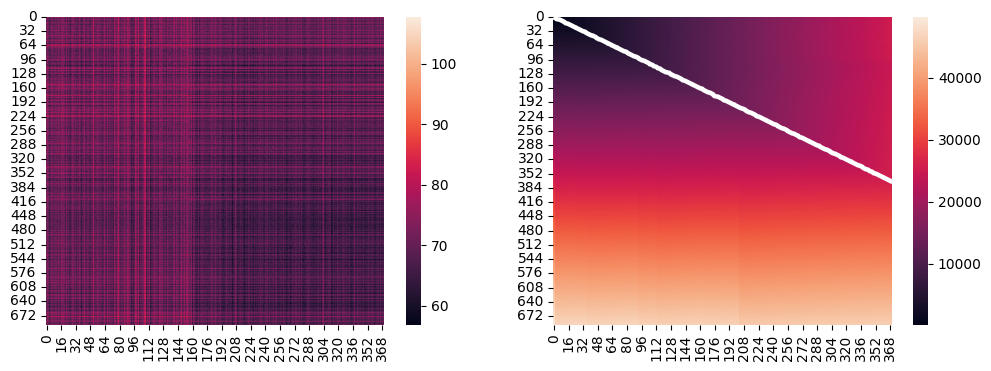

In [9]:
bad_d1_id = 3
bad_d2_id = 18
bad = results[bad_d1_id][bad_d2_id][0]

bad_dataset1 = read_with_pc(f"data/rep{id_name[bad_d1_id]['rep']}_{id_name[bad_d1_id]['cell_type']}_subset{id_name[bad_d1_id]['subset']}_hvg.h5ad")
bad_dataset2 = read_with_pc(f"data/rep{id_name[bad_d2_id]['rep']}_{id_name[bad_d2_id]['cell_type']}_subset{id_name[bad_d2_id]['subset']}_hvg.h5ad")

bad.plot_cost_distances()

In [10]:
bad_dataset1 = bad_dataset1[np.argsort(bad_dataset1.obs["pseudotime"])]
bad_dataset2 = bad_dataset2[np.argsort(bad_dataset2.obs["pseudotime"])]

/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:116: ImplicitModificationWarning: Setting element `.obsm['dtw_cost']` of view, initializing view as actual.
  reference.obsm[f"{dtw_key}_cost"] = cost
/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:120: ImplicitModificationWarning: Setting element `.obsm['dtw_cost']` of view, initializing view as actual.
  query.obsm[f"{dtw_key}_cost"] = cost.T


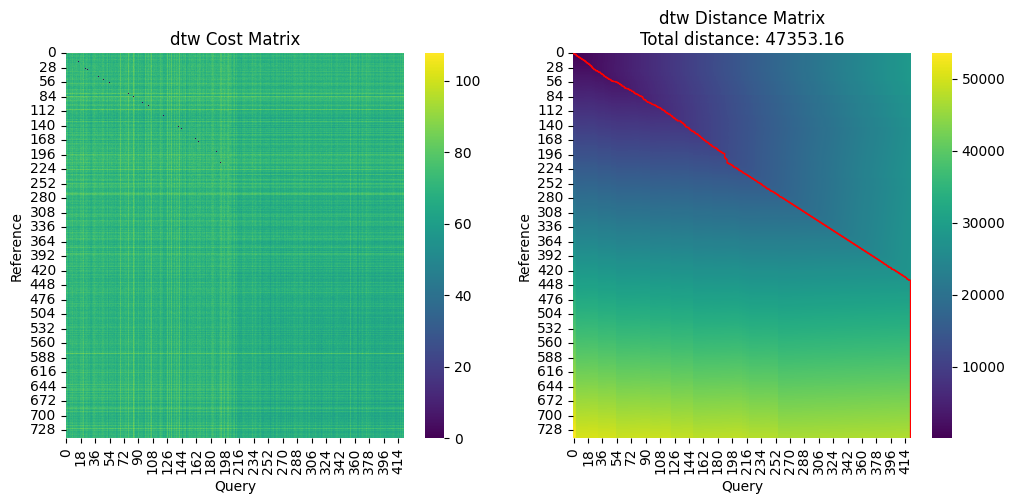

In [11]:
import dynchro

# run dynchro on bad_dataset1 and bad_dataset2
bad_result = dynchro.tl.dynchronize(
    bad_dataset1,
    bad_dataset2)

bad_result

In [12]:
# cell 439 onwards is mapped on the last spot, of dataset2

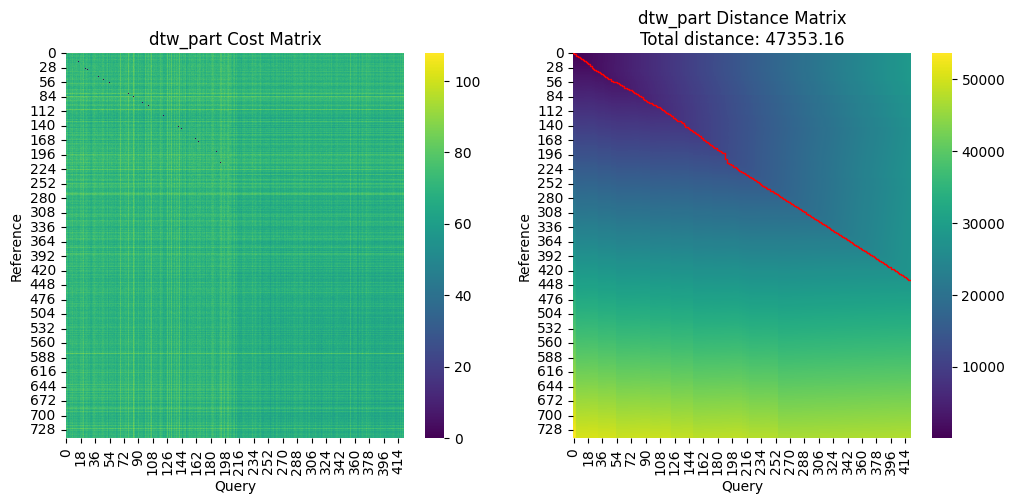

In [13]:
reference = bad_dataset1
query = bad_dataset2
dtw_key = "dtw_part"
pseudotime_key = "pseudotime"
mode = "copy"

reference, query = dynchro.tl.dtw(reference, query, dtw_key = dtw_key, pseudotime_key = pseudotime_key, mode = mode)
reference, query = dynchro.tl.traceback(reference, query, dtw_key = dtw_key, mode = mode, end_x = 439)
query = dynchro.tl.warp_pseudotime(reference, query, dtw_key = dtw_key, pseudotime_key = pseudotime_key, mode = mode)
reference = dynchro.tl.warp_pseudotime(query, reference, dtw_key = dtw_key, pseudotime_key = pseudotime_key, mode = mode)

dynchro.pl.plot_dtw_matrices(reference, query, dtw_key)

defaultdict(<class 'list'>, {'Run5_160440090049398': np.float64(75.57972326880926), 'Run5_231366222036334': np.float64(76.1737015635885), 'Run5_125745312717548': np.float64(67.44106159184638), 'Run5_204911343230388': np.float64(65.9528895016393), 'Run4_205449168842099': np.float64(71.2334955292507), 'Run5_199865964586907': np.float64(71.80014449809153), 'Run4_231366208678709': np.float64(72.10657851755647), 'Run4_161960476957420': np.float64(69.14013600213966), 'Run5_134376349710253': np.float64(69.12101935602804), 'Run5_236846706747291': np.float64(72.6953800846238), 'Run4_239932655712989': np.float64(70.62548885379408), 'Run5_232327461693355': np.float64(72.82234884119838), 'Run5_126886699977564': np.float64(71.71333742734944), 'Run5_170198344260909': np.float64(70.77652452910806), 'Run5_166351409900901': np.float64(70.67096270545821), 'Run5_230816707439524': np.float64(71.95957415838134), 'Run4_231280295430566': np.float64(34.582832998157166), 'Run5_226874746686838': np.float64(74.2

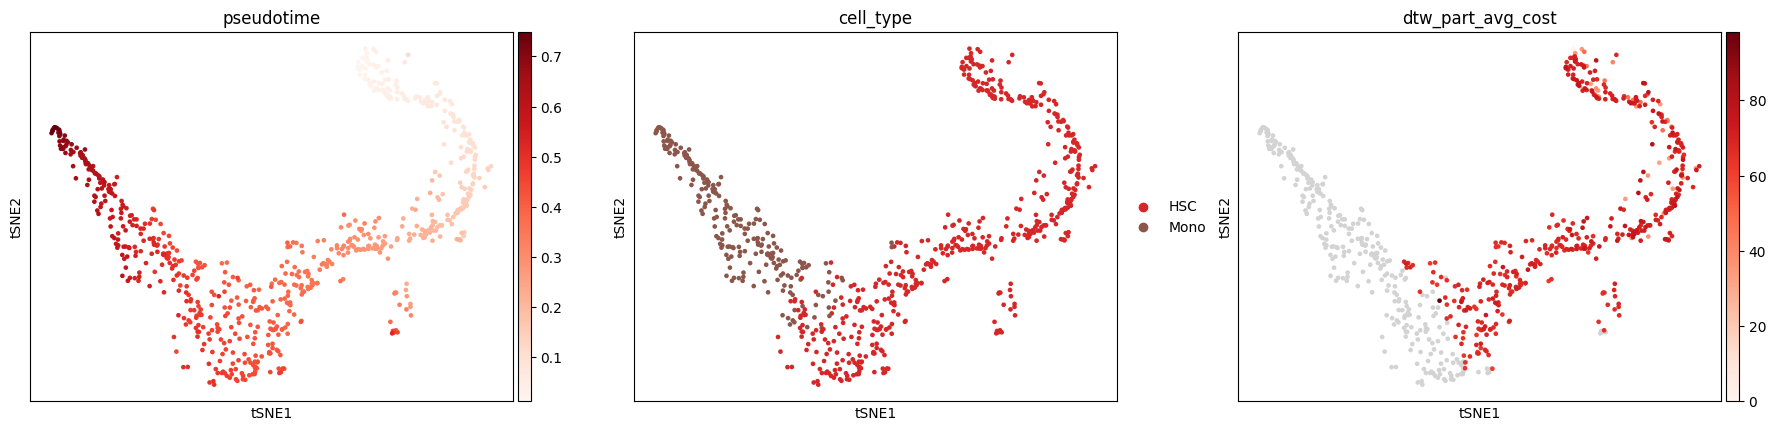

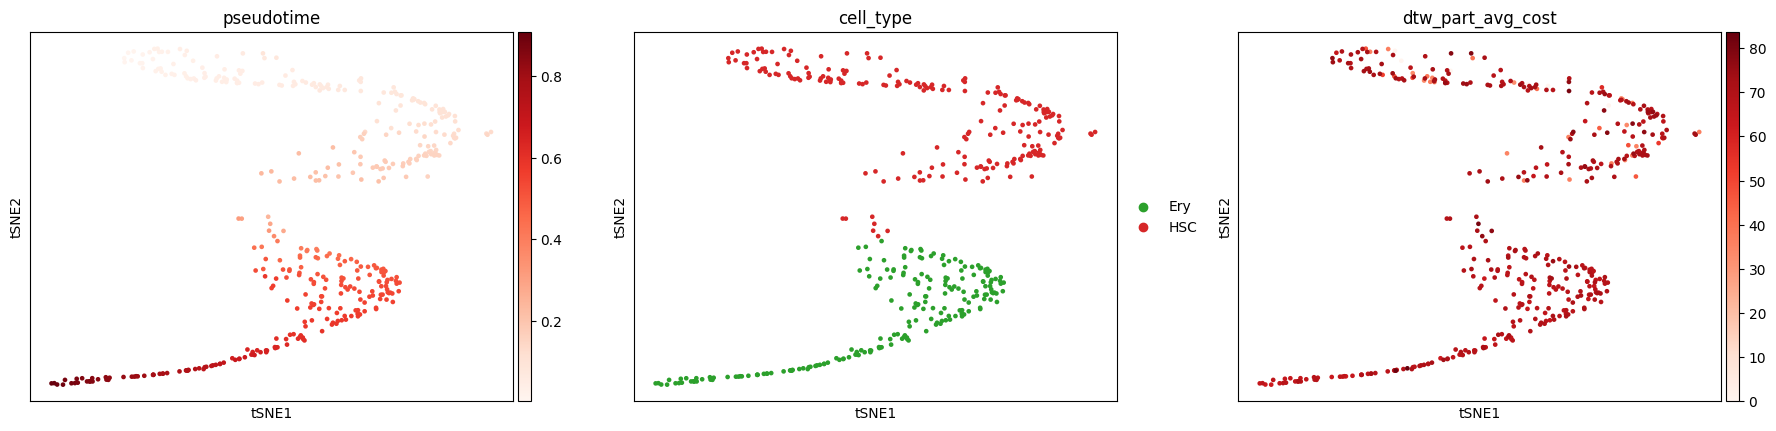

In [14]:
reference = dynchro.tl.avg_cost_path(reference, dtw_key="dtw_part")
query = dynchro.tl.avg_cost_path(query, dtw_key="dtw_part")

# bad_path1 = flatten(bad.path1().values())
# bad_path2 = flatten(bad.path2().values())

# bad_dataset1, bad_dataset2 = assign_cost(bad_path1, bad_path2, bad.cost(), bad_dataset1, bad_dataset2)

sc.pl.tsne(reference, color = ["pseudotime", "cell_type", "dtw_part_avg_cost"], cmap= "Reds", s = 45)
sc.pl.tsne(query, color = ["pseudotime", "cell_type", "dtw_part_avg_cost"], cmap= "Reds", s = 45)

In [15]:
reference.obs.dtw_part_avg_cost

index
Run5_160440090049398    75.579723
Run5_231366222036334    76.173702
Run5_125745312717548    67.441062
Run5_204911343230388    65.952890
Run4_205449168842099    71.233496
                          ...    
Run5_129583031437660          NaN
Run4_236221682007389          NaN
Run5_231822803233142          NaN
Run4_164753398685099          NaN
Run4_120703409580963          NaN
Name: dtw_part_avg_cost, Length: 744, dtype: float64

1501 1501


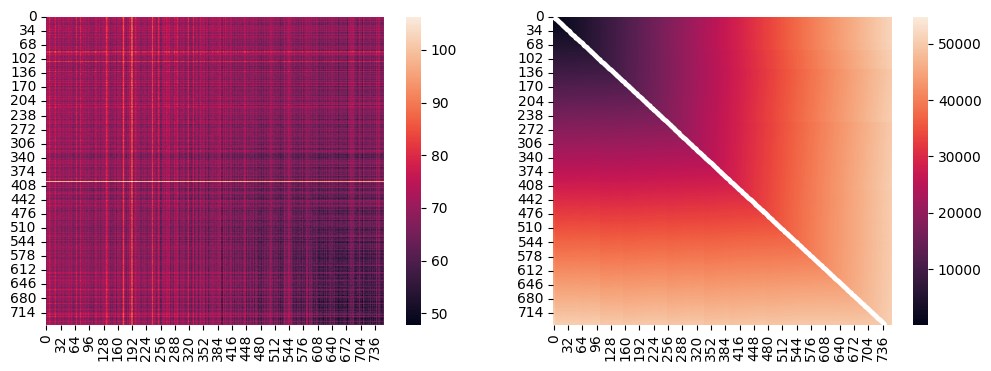

In [16]:
good_d1_id = 3
good_d2_id = 9
good = results[good_d1_id][good_d2_id][0]

good_dataset1 = read_with_pc(f"data/rep{id_name[good_d1_id]['rep']}_{id_name[good_d1_id]['cell_type']}_subset{id_name[good_d1_id]['subset']}_hvg.h5ad")
good_dataset2 = read_with_pc(f"data/rep{id_name[good_d2_id]['rep']}_{id_name[good_d2_id]['cell_type']}_subset{id_name[good_d2_id]['subset']}_hvg.h5ad")

good.plot_cost_distances()

In [17]:
good_dataset1.X

array([[ 3.546875  , -0.07574463, -0.18798828, ..., -0.36816406,
        -0.36450195, -0.8803711 ],
       [ 3.2167969 , -0.07574463, -0.18798828, ..., -0.36816406,
         2.7832031 , -0.8803711 ],
       [-0.8461914 , -0.07574463, -0.18798828, ..., -0.36816406,
        -0.36450195,  2.6113281 ],
       ...,
       [-0.8461914 , -0.07574463, -0.18798828, ..., -0.36816406,
        -0.36450195,  2.3085938 ],
       [-0.8461914 , -0.07574463, -0.18798828, ..., -0.36816406,
        -0.36450195, -0.8803711 ],
       [-0.8461914 , -0.07574463, -0.18798828, ..., -0.36816406,
        -0.36450195, -0.8803711 ]], shape=(744, 2082), dtype=float32)

In [18]:
good_dataset2.X

array([[-0.6279297 , -0.07434082, -0.20227051, ..., -0.35302734,
        -0.35864258, -0.62890625],
       [-0.6279297 , -0.07434082, -0.20227051, ..., -0.35302734,
        -0.35864258, -0.62890625],
       [-0.6279297 ,  2.6601562 , -0.20227051, ..., -0.35302734,
        -0.35864258, -0.62890625],
       ...,
       [-0.6279297 , -0.07434082, -0.20227051, ...,  3.0839844 ,
        -0.35864258, -0.62890625],
       [-0.6279297 , -0.07434082, -0.20227051, ..., -0.35302734,
        -0.35864258,  3.375     ],
       [-0.6279297 , -0.07434082, -0.20227051, ..., -0.35302734,
        -0.35864258, -0.62890625]], shape=(758, 2075), dtype=float32)

In [19]:
# find common genes
common_genes = np.intersect1d(good_dataset1.var_names, good_dataset2.var_names)
print(f"Common genes: {len(common_genes)}")

# select
good_dataset1 = good_dataset1[:, common_genes]
good_dataset2 = good_dataset2[:, common_genes]

good_dataset1 = good_dataset1[np.argsort(good_dataset1.obs["pseudotime"])]
good_dataset2 = good_dataset2[np.argsort(good_dataset2.obs["pseudotime"])]

Common genes: 2062


/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:116: ImplicitModificationWarning: Setting element `.obsm['dtw_cost']` of view, initializing view as actual.
  reference.obsm[f"{dtw_key}_cost"] = cost
/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:120: ImplicitModificationWarning: Setting element `.obsm['dtw_cost']` of view, initializing view as actual.
  query.obsm[f"{dtw_key}_cost"] = cost.T


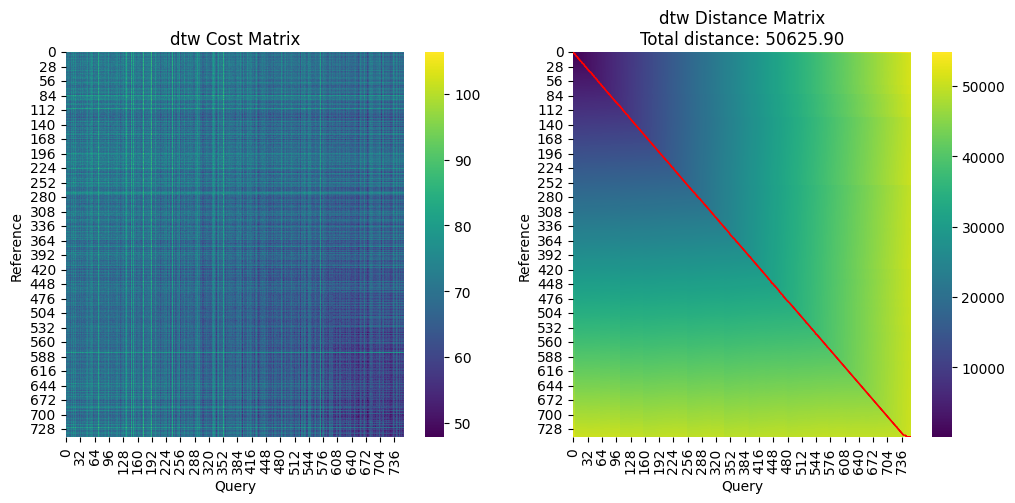

In [20]:
good_result = dynchro.tl.dynchronize(
    good_dataset1,
    good_dataset2
)

In [21]:
def assign_cost(path1, path2, matrix, dataset1, dataset2):
    cost1, cost2 = avg_cost_path(pathx=path2, pathy=path1, matrix=matrix, datasetx=dataset1, datasety=dataset2)

    dataset1.obs["avg_cost"] = cost1
    dataset2.obs["avg_cost"] = cost2

    # sc.pl.scatter(dataset1, x="pseudotime", y="avg_cost", color="cell_type", title="Dataset 1 Average Cost vs Pseudotime")
    # sc.pl.scatter(dataset2, x="pseudotime", y="avg_cost", color="cell_type", title="Dataset 2 Average Cost vs Pseudotime")

    return dataset1, dataset2

defaultdict(<class 'list'>, {'Run5_160440090049398': np.float64(75.57972326880926), 'Run5_231366222036334': np.float64(76.1737015635885), 'Run5_125745312717548': np.float64(67.44106159184638), 'Run5_204911343230388': np.float64(65.9528895016393), 'Run4_205449168842099': np.float64(71.2334955292507), 'Run5_199865964586907': np.float64(71.80014449809153), 'Run4_231366208678709': np.float64(72.10657851755647), 'Run4_161960476957420': np.float64(69.14013600213966), 'Run5_134376349710253': np.float64(69.12101935602804), 'Run5_236846706747291': np.float64(72.6953800846238), 'Run4_239932655712989': np.float64(70.62548885379408), 'Run5_232327461693355': np.float64(72.82234884119838), 'Run5_126886699977564': np.float64(71.71333742734944), 'Run5_170198344260909': np.float64(70.77652452910806), 'Run5_166351409900901': np.float64(70.67096270545821), 'Run5_230816707439524': np.float64(71.95957415838134), 'Run4_231280295430566': np.float64(34.582832998157166), 'Run5_226874746686838': np.float64(74.2

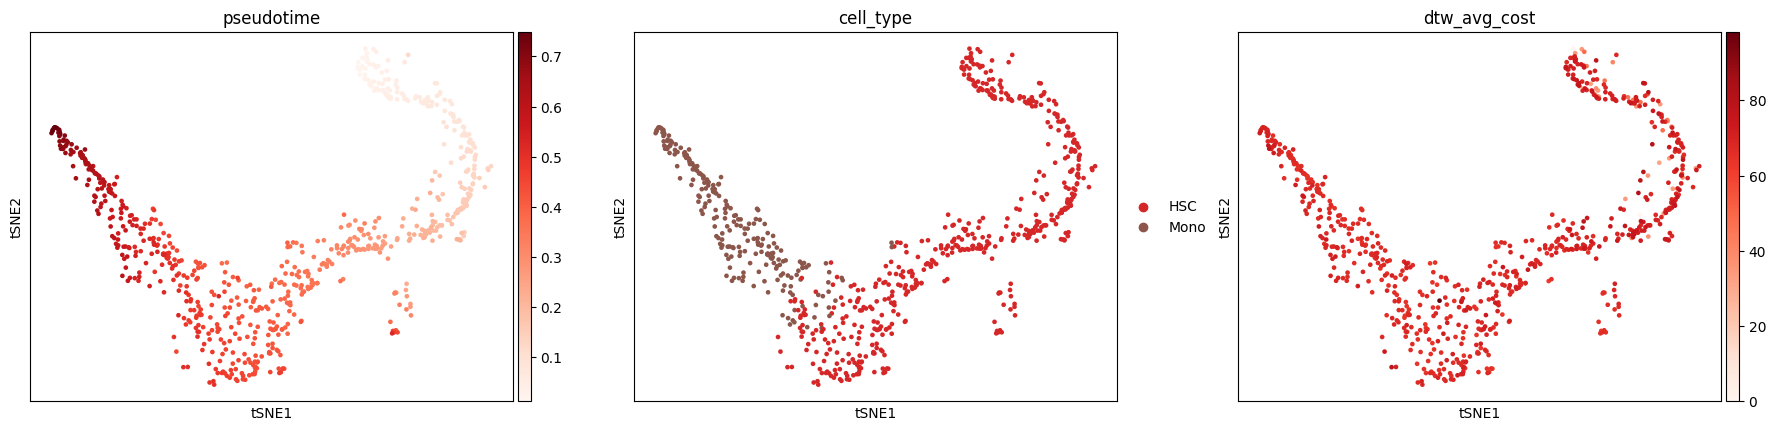

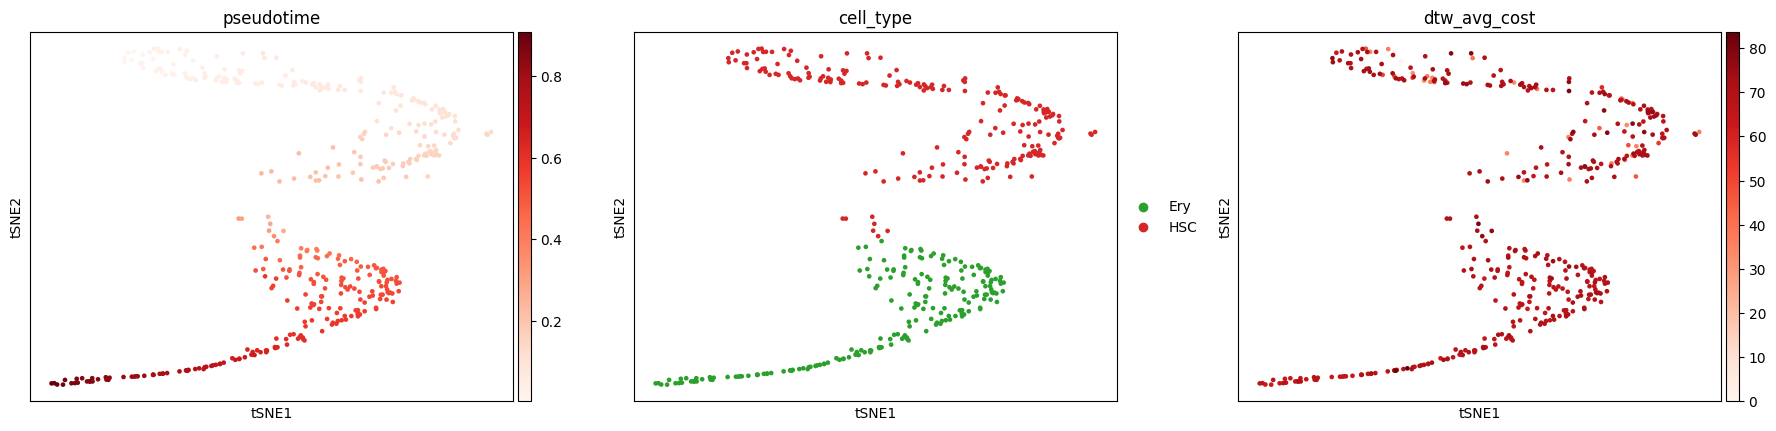

In [22]:
bad_dataset1 = dynchro.tl.avg_cost_path(bad_dataset1)
bad_dataset2 = dynchro.tl.avg_cost_path(bad_dataset2)

# bad_path1 = flatten(bad.path1().values())
# bad_path2 = flatten(bad.path2().values())

# bad_dataset1, bad_dataset2 = assign_cost(bad_path1, bad_path2, bad.cost(), bad_dataset1, bad_dataset2)

sc.pl.tsne(bad_dataset1, color = ["pseudotime", "cell_type", "dtw_avg_cost"], cmap= "Reds", s = 45)
sc.pl.tsne(bad_dataset2, color = ["pseudotime", "cell_type", "dtw_avg_cost"], cmap= "Reds", s = 45)


In [23]:
good_dataset1.obs

clusters  palantir_pseudotime  palantir_diff_potential  \
index                                                                         
Run5_160440090049398        0             0.012352                 1.421627   
Run5_231366222036334        0             0.012433                 1.421646   
Run5_125745312717548        0             0.012570                 1.421743   
Run5_204911343230388        0             0.013863                 1.421590   
Run4_205449168842099        0             0.014458                 1.421574   
...                       ...                  ...                      ...   
Run5_129583031437660        3             0.739672                 0.284601   
Run4_236221682007389        3             0.743987                 0.253808   
Run5_231822803233142        3             0.746279                 0.250693   
Run4_164753398685099        3             0.748845                 0.260523   
Run4_120703409580963        3             0.748991                 0.279959   

                     cell_type milestones  pseudotime  Mono  \
index                                                         
Run5_160440090049398       HSC          0    0.012352  True   
Run5_231366222036334       HSC          0    0.012433  True   
Run5_125745312717548       HSC          0    0.012570  True   
Run5_204911343230388       HSC          0    0.013863  True   
Run4_205449168842099       HSC          0    0.014458  True   
...                        ...        ...         ...   ...   
Run5_129583031437660      Mono          3    0.739672  True   
Run4_236221682007389      Mono          3    0.743987  True   
Run5_231822803233142      Mono          3    0.746279  True   
Run4_164753398685099      Mono          3    0.748845  True   
Run4_120703409580963      Mono          3    0.748991  True   

                                                               dtw_path  \
index                                                                     
Run5_160440090049398                                                [0]   
Run5_231366222036334                                             [0, 1]   
Run5_125745312717548                                             [1, 2]   
Run5_204911343230388                                          [2, 3, 4]   
Run4_205449168842099                                             [4, 5]   
...                                                                 ...   
Run5_129583031437660                                         [739, 740]   
Run4_236221682007389                     [740, 741, 742, 743, 744, 745]   
Run5_231822803233142                                         [745, 746]   
Run4_164753398685099                                         [746, 747]   
Run4_120703409580963  [747, 748, 749, 750, 751, 752, 753, 754, 755, ...   

                                                         dtw_cells_path  \
index                                                                     
Run5_160440090049398                             [Run2_240617688264027]   
Run5_231366222036334       [Run2_240617688264027, Run2_226883188157787]   
Run5_125745312717548       [Run2_226883188157787, Run2_125197018348269]   
Run5_204911343230388  [Run2_125197018348269, Run2_125042414245678, R...   
Run4_205449168842099       [Run3_125677920967413, Run1_235214350772126]   
...                                                                 ...   
Run5_129583031437660       [Run1_130203904335069, Run3_131217400711603]   
Run4_236221682007389  [Run3_131217400711603, Run3_126706324453213, R...   
Run5_231822803233142       [Run3_162090668640611, Run2_162001560124659]   
Run4_164753398685099       [Run2_162001560124659, Run1_234992248151403]   
Run4_120703409580963  [Run1_234992248151403, Run2_239475388177118, R...   

                      dtw_warped_pseudotime  
index                                        
Run5_160440090049398               0.006575  
Run5_231366222036334               0.006575  
Run5_125745312717548               0.

defaultdict(<class 'list'>, {'Run5_160440090049398': np.float64(72.89775511330379), 'Run5_231366222036334': np.float64(72.18473545922365), 'Run5_125745312717548': np.float64(67.2968870452045), 'Run5_204911343230388': np.float64(67.38530173624493), 'Run4_205449168842099': np.float64(70.63003608751961), 'Run5_199865964586907': np.float64(73.31353703271134), 'Run4_231366208678709': np.float64(73.58908275123231), 'Run4_161960476957420': np.float64(74.21588160887794), 'Run5_134376349710253': np.float64(72.31493187422629), 'Run5_236846706747291': np.float64(71.42881429647764), 'Run4_239932655712989': np.float64(66.98366492580756), 'Run5_232327461693355': np.float64(70.25984937548978), 'Run5_126886699977564': np.float64(74.70559573970144), 'Run5_170198344260909': np.float64(73.1801637225686), 'Run5_166351409900901': np.float64(70.95579187673425), 'Run5_230816707439524': np.float64(71.14663692457793), 'Run4_231280295430566': np.float64(68.9159747595474), 'Run5_226874746686838': np.float64(74.6

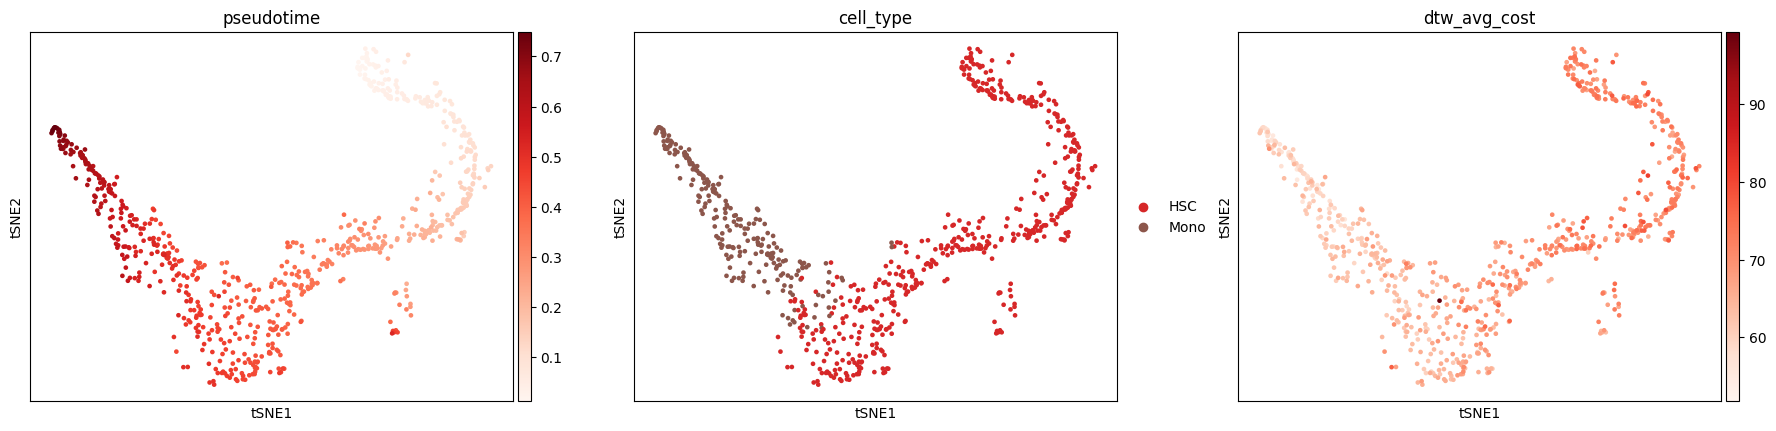

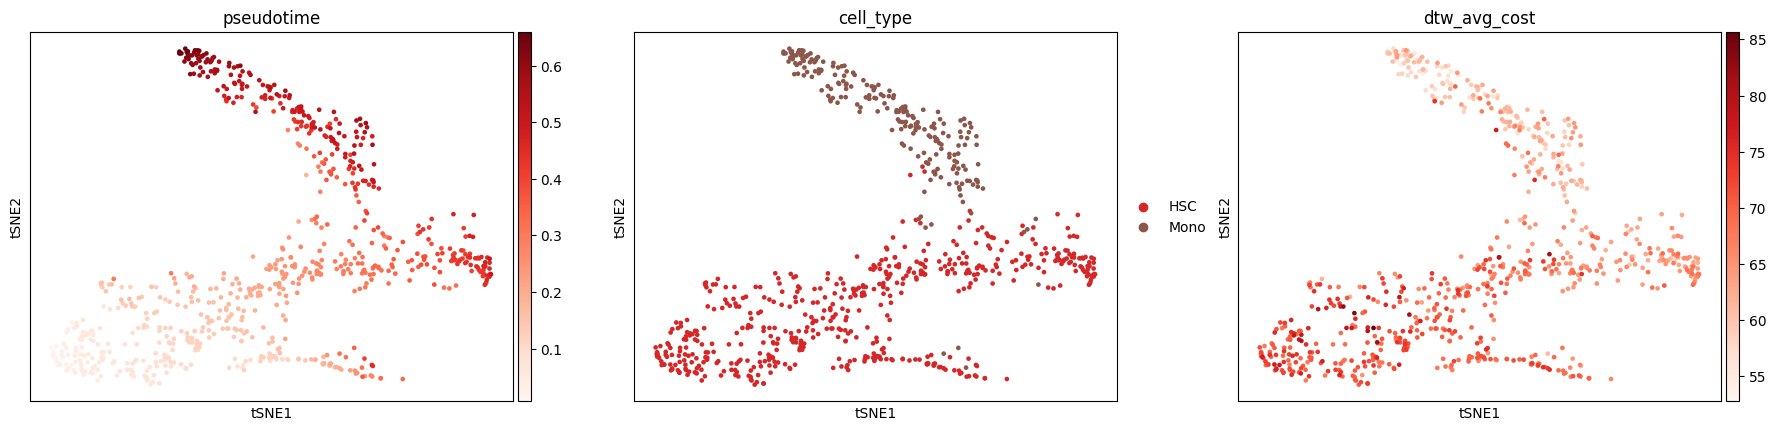

In [24]:
# good_path1 = flatten(good.path1().values())
# good_path2 = flatten(good.path2().values())

# good_dataset1, good_dataset2 = assign_cost(good_path1, good_path2, good.cost(), good_dataset1, good_dataset2)

good_dataset1 = dynchro.tl.avg_cost_path(good_dataset1)
good_dataset2 = dynchro.tl.avg_cost_path(good_dataset2)

sc.pl.tsne(good_dataset1, color = ["pseudotime", "cell_type", "dtw_avg_cost"], cmap= "Reds", s = 45)
sc.pl.tsne(good_dataset2, color = ["pseudotime", "cell_type", "dtw_avg_cost"], cmap= "Reds", s = 45)


# Scatterplot figures

In [25]:
def get_colors(colors, labels):
    color_map = {label: colors[i] for i, label in enumerate(np.unique(labels))}
    translated_colors = np.array([color_map[c] for c in labels])

    handles, labels = get_color_legend(color_map)

    return translated_colors, handles, labels

def get_color_legend(color_map):
    handles = [
        plt.Line2D(
                [0], [0], marker='o', markerfacecolor=c, color = "k", 
                markersize = 9, lw = 0
            ) for c in color_map.values()
        ]
    labels = list(color_map.keys())
    return handles, labels

In [112]:
def plot_celltypes(adata, axes, colors = None):
    xs = adata.obsm['X_tsne'][:, 0]
    ys = adata.obsm['X_tsne'][:, 1]
    labels = adata.obs['cell_type'].values

    if colors is None:
        colors = ["#EF69BA", "#EF7269", "#EFCB69", "#BAEF69", "#69EF72", "#69EFCB", "#69BAEF", "#7269EF", "#CB69EF"]
        colors = [
            "#4269d0", 
            "#efb118",
            "#ff725c",
            "#6cc5b0",
            "#3ca951",
            "#ff8ab7",
            "#a463f2",
            "#97bbf5",
            "#9c6b4e",
            "#9498a0"
        ]
        colors = [colors[1], colors[5]]

    translated_colors, handles, labels = get_colors(colors, labels)

    ax = axes[0]

    ax.scatter(xs, ys, c=translated_colors,  s=75, edgecolors = 'k')
    # ax.set_title("Cell types")

    ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    # ax.set_xlabel("Flat tree plot")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.xaxis.set_label_coords(0.25, 0.95)
    ax.set_ylabel("")
    
    axes[1].axis('off')

    axes[1].legend(handles=handles, labels=labels, title="", loc='best', frameon=False, fontsize="xx-small", title_fontsize="small")
    
    return ax

In [127]:
import seaborn as sns
import matplotlib.colors as clr
import matplotlib as mpl
def plot_pseudotime(adata, axes, title, ticks, label, labelx, labely, labels=None, colors=None):

    xs = adata.obsm['X_tsne'][:, 0]
    ys = adata.obsm['X_tsne'][:, 1]
    if labels is None:
        labels = adata.obs['pseudotime'].values
        labels = (labels - labels.min()) / (labels.max() - labels.min())

    if colors is None:
        tints = ["#69BAEF", "#80C2F1", "#95CBF3", "#A9D3F5", "#BBDCF7", "#CDE5F9", "#DEEDFB", "#EEF6FD", "#FFFFFF"]
        shades = ["#4DA2D5", "#2C8ABC", "#0073A3", "#005D8B", "#004774"][::-1]
        colors = shades + tints

    palette = clr.LinearSegmentedColormap.from_list("custom", colors, N=256)
    palette.set_bad("lightgrey")

    ax = axes[0]
    ax.scatter(xs, ys, c=labels, cmap=palette, s=75, edgecolors = 'k', plotnonfinite=True)

    norm = mpl.colors.Normalize(vmin=labels.min(), vmax=labels.max())

    axes[1].axis('off')

    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=palette),
                ax=axes[1], orientation='vertical', label='',
                fraction=0.75, shrink=0.75, ticks=ticks)
    
    axes[1].text(labelx, labely, label, rotation = 90, horizontalalignment='center', verticalalignment='center', fontsize=8)

    # ax.set_title(title)

    ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    # ax.set_xlabel("Flat tree plot")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.xaxis.set_label_coords(0.25, 0.95)
    ax.set_ylabel("")


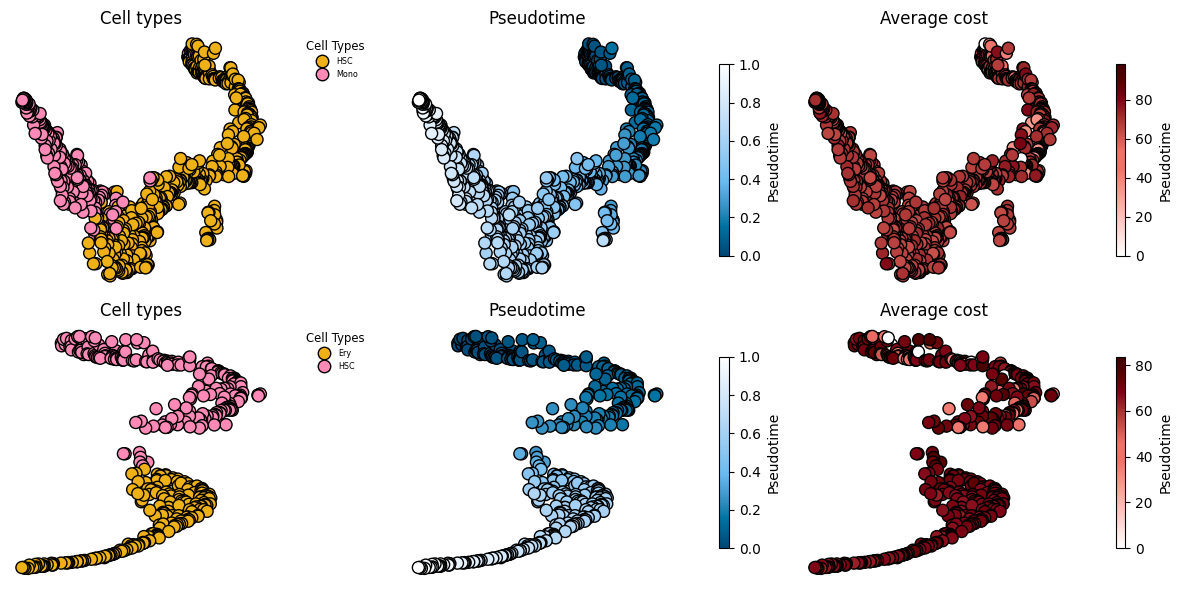

In [28]:
fig, axes = plt.subplots(2, 6, figsize=(12, 6), gridspec_kw={'width_ratios': [8, 2, 8, 2, 8, 2]})
plot_celltypes(bad_dataset1, [axes[0, 0], axes[0, 1]])
plot_celltypes(bad_dataset2, [axes[1, 0], axes[1, 1]])

plot_pseudotime(bad_dataset1, [axes[0, 2], axes[0, 3]], "Pseudotime")
plot_pseudotime(bad_dataset2, [axes[1, 2], axes[1, 3]], "Pseudotime")

red_tints = ['#EF7269', '#F78F85', '#FCACA2', '#FFC7C0', '#FFE3DF', '#FFFFFF'][::-1]
red_shades = ['#EF7269', '#C8504B', '#A22E2E', '#7D0214', '#5A0000', '#3E0000']

red_colors = red_tints + red_shades

plot_pseudotime(bad_dataset1, [axes[0, 4], axes[0, 5]], "Average cost", labels=bad_dataset1.obs["dtw_avg_cost"].values, colors=red_colors)
plot_pseudotime(bad_dataset2, [axes[1, 4], axes[1, 5]], "Average cost", labels=bad_dataset2.obs["dtw_avg_cost"].values, colors=red_colors)
plt.tight_layout()

In [29]:
def plot_avg_cost(values, pseudotimes, ax, color):
    xvals1 = (pseudotimes - np.min(pseudotimes)) / (np.max(pseudotimes) - np.min(pseudotimes))
    ax.scatter(xvals1, values, c=color, s=20, edgecolors = 'k')
    ax.set_xlabel("Pseudotime")
    ax.set_ylabel("Average cost")

    b, a = np.polyfit(xvals1[:-1], values[:-1], 1)
    ax.plot(xvals1, a + b * xvals1, color='black', linestyle='--', label="Trend line")

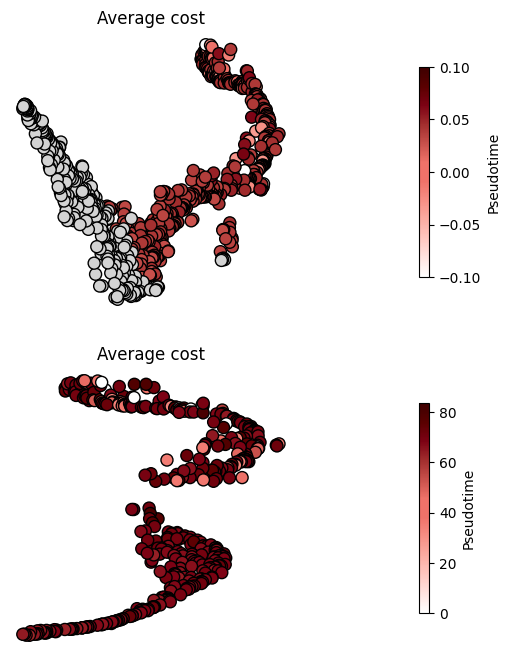

In [260]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

plot_pseudotime(reference, [axes[0, 0], axes[0, 1]], "Average cost", labels=reference.obs["dtw_part_avg_cost"].values, colors=red_colors)
plot_pseudotime(query, [axes[1, 0], axes[1, 1]], "Average cost", labels=query.obs["dtw_part_avg_cost"].values, colors=red_colors)

In [35]:
with open("data/results_no_dup_hvg_dist_norm.pkl", "rb") as f:
    dist_norm = pickle.load(f)

In [50]:
dist_norm

[[0,
  np.float64(0.09085814409178214),
  np.float64(0.09100652658701235),
  np.float64(0.0907725622885589),
  np.float64(0.09090802734975341),
  np.float64(0.08910039247338782),
  np.float64(0.08967774498568289),
  np.float64(0.08947058358689615),
  np.float64(0.08894037699277364),
  np.float64(0.08934970473064509),
  np.float64(0.08507419466533692),
  np.float64(0.08502786245612343),
  np.float64(0.08510598659854109),
  np.float64(0.08509864027887903),
  np.float64(0.08518806334581602),
  np.float64(0.17431821327076213),
  np.float64(0.17713262645134456),
  np.float64(0.1763761937751334),
  np.float64(0.17203049764087866),
  np.float64(0.17768672030377092),
  np.float64(0.12434534349355243),
  np.float64(0.12470001025419986),
  np.float64(0.12537833199619172),
  np.float64(0.12480203182459437),
  np.float64(0.12501226443754096),
  np.float64(0.12621869867817587),
  np.float64(0.12646489623181378),
  np.float64(0.12628173782477334),
  np.float64(0.12616744424161758),
  np.float64(0.12

In [62]:
dist_norm

[[0,
  np.float64(0.09085814409178214),
  np.float64(0.09100652658701235),
  np.float64(0.0907725622885589),
  np.float64(0.09090802734975341),
  np.float64(0.08910039247338782),
  np.float64(0.08967774498568289),
  np.float64(0.08947058358689615),
  np.float64(0.08894037699277364),
  np.float64(0.08934970473064509),
  np.float64(0.08507419466533692),
  np.float64(0.08502786245612343),
  np.float64(0.08510598659854109),
  np.float64(0.08509864027887903),
  np.float64(0.08518806334581602),
  np.float64(0.17431821327076213),
  np.float64(0.17713262645134456),
  np.float64(0.1763761937751334),
  np.float64(0.17203049764087866),
  np.float64(0.17768672030377092),
  np.float64(0.12434534349355243),
  np.float64(0.12470001025419986),
  np.float64(0.12537833199619172),
  np.float64(0.12480203182459437),
  np.float64(0.12501226443754096),
  np.float64(0.12621869867817587),
  np.float64(0.12646489623181378),
  np.float64(0.12628173782477334),
  np.float64(0.12616744424161758),
  np.float64(0.12

In [61]:
res

array([11, 13, 10, 12, 14,  6,  7,  9,  5,  8,  2,  4,  1,  0,  3, 22, 24,
       23, 20, 21, 26, 27, 28, 25, 29, 16, 17, 19, 15, 18], dtype=int32)

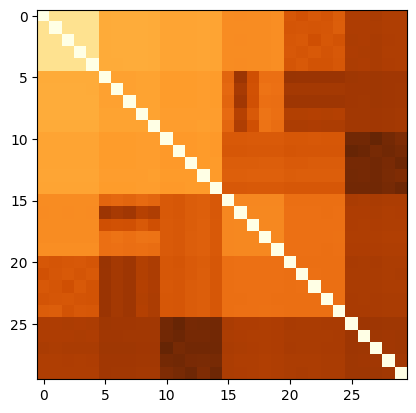

In [65]:
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as ssd

data_form = ssd.squareform(dist_norm)

link = sch.linkage(data_form, method='ward')

res = sch.leaves_list(link)

#reorder dist_norm according to res
dist_norm_np = np.array(dist_norm)
dist_norm2 = dist_norm_np[res][:, res]

dist_norm2

plt.imshow(dist_norm2, cmap='YlOrBr')

In [66]:
def heatmap_indices(data):
    p = sns.clustermap(
        data,
        xticklabels = [],
        yticklabels = [],
        method = "ward",
        cbar_pos = None,
        # cbar_kws = {"location": "right", "label": "Normalized DTW distance"},
        dendrogram_ratio=(0, 0),
        cmap="YlOrBr",
        figsize=(5, 5)
        # axes = axes[0],
        # linewidths = 0.01,
    )

    ax = p.ax_heatmap

    # annotate x, y square in red
    # if x is not None and y is not None:
    #     ax.add_patch(plt.Rectangle((x, y), 1, 1, fill=False, edgecolor='red', lw=2))

    return ax, p.dendrogram_row.reordered_ind, p.dendrogram_col.reordered_ind

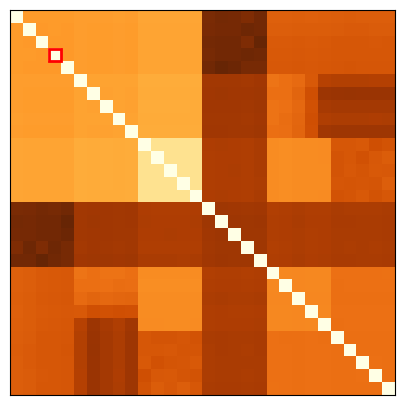

In [76]:
def plot_heatmap(data, ax, xind, yind):
    ax.imshow(data, cmap='YlOrBr')
    ax.set_xticks([])
    ax.set_yticks([])

    ax.add_patch(plt.Rectangle((xind, yind), 1, 1, fill=False, edgecolor='red', lw=2))

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_heatmap(dist_norm, ax, 2.5, 2.5)

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


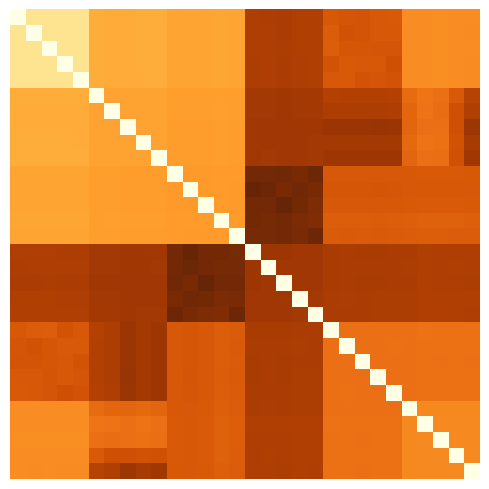

In [67]:
_, rowind, colind = heatmap_indices(dist_norm)

dist_norm_reordered = dist_norm_np[rowind][:, colind]

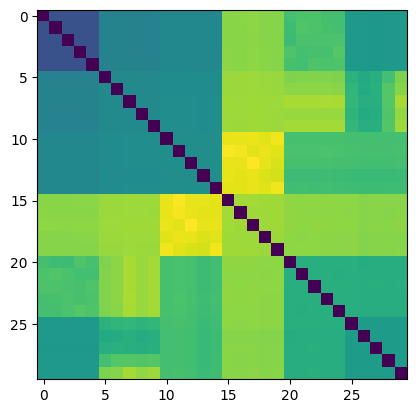

In [69]:
plt.imshow(dist_norm_reordered)

In [146]:
from moepy import lowess

def calculate_lowess(adata, dtw_key = "dtw", pseudotime_key="norm_pseudotime"):
    average_cost = adata.obs.sort_values(pseudotime_key)[f"{dtw_key}_avg_cost"].values
    xvals = adata.obs.sort_values(pseudotime_key)[pseudotime_key].values

    quant_reg_func = lowess.calc_quant_reg_betas
    quantile_model = lowess.Lowess(reg_func=quant_reg_func)

    quantile_model.fit(xvals, average_cost, frac=0.3)
    x_pred = np.linspace(xvals.min(), xvals.max(), 100)
    y_pred = quantile_model.predict(x_pred)

    df_quantiles = lowess.quantile_model(xvals, average_cost, frac=0.3, num_fits=100)

    return xvals, x_pred, y_pred, df_quantiles, average_cost

def norm(x):
    return (x - x.min()) / (x.max() - x.min())

bad_dataset1.obs["norm_pseudotime"] = norm(bad_dataset1.obs["pseudotime"])
lowess_bad1 = calculate_lowess(bad_dataset1, dtw_key="dtw", pseudotime_key="norm_pseudotime")
good_dataset1.obs["norm_pseudotime"] = norm(good_dataset1.obs["pseudotime"])
lowess_good1 = calculate_lowess(good_dataset1, dtw_key="dtw", pseudotime_key="norm_pseudotime")

100%|██████████| 9/9 [00:19<00:00,  2.16s/it]


In [158]:
def plot_avg_cost(lowess_arg, title, color, ax, removedspines=['top', 'right', 'bottom', 'left']):
    pt, x, y, quantile_df, avg_cost = lowess_arg

    ax.scatter(pt, avg_cost, label="Average Cost Path", color=color, alpha=1, edgecolors='k')

    ax.plot(x, y, color='black', linestyle='-', label='Trend Line (LOWESS)')
    ax.fill_between(quantile_df.index, quantile_df[0.1], quantile_df[0.9], color=colors[1], edgecolor='face', linewidth=0, alpha=0.45, label='10-90% Prediction Interval')

    # trendline
    b, a = np.polyfit(x, y, 1)
    ax.plot(x, a + b * x, color='grey', linestyle='--', label='Trend Line (Linear Fit)')

    # ax.scatter(data.obs.sort
    # dynchro.pl.plot_avg_cost_path(data, pseudotime_key="norm_pseudotime", dtw_key=dtw_key, color=color, ax=ax)
    if removedspines is not None:
        ax.spines[removedspines].set_visible(False)
    # ax.get_legend().remove()
    ax.set_title("")
    ax.xaxis.label.set_visible(False)
    ax.yaxis.label.set_visible(False)

In [207]:
def flatten(values : list) -> list:
    """
    Flatten a list of lists into a single list.
    """
    flat_list = []

    for sublist in values:
        if isinstance(sublist, list):
            # If the item is a list, extend the result with its contents
            flat_list.extend(sublist)
        else:
            # If the item is not a list, append it directly if it is not None
            if sublist is not None:
                flat_list.append(sublist)

    return flat_list


def plot_matrix(matrix, axes, xticks, yticks, pathx, pathy):
    im = axes[0].imshow(matrix, cmap='viridis', aspect='auto')
    # axes.set_title(title)
    axes[0].set_xticks(xticks)
    axes[0].set_yticks(yticks)

    # plot colorbar
    fig.colorbar(im, ax=axes[0], fraction=0.75, shrink=0.8, pad=0.03)
    # plt.colorbar(im, ax=axes[1], fraction=0.75, shrink=0.75)
    path1 = flatten(pathx) #flatten(reference.obs[f"{dtw_key}_path"])
    path2 = flatten(pathy) #flatten(query.obs[f"{dtw_key}_path"])

    axes[0].plot(path1, path2, color='red', linewidth=1)

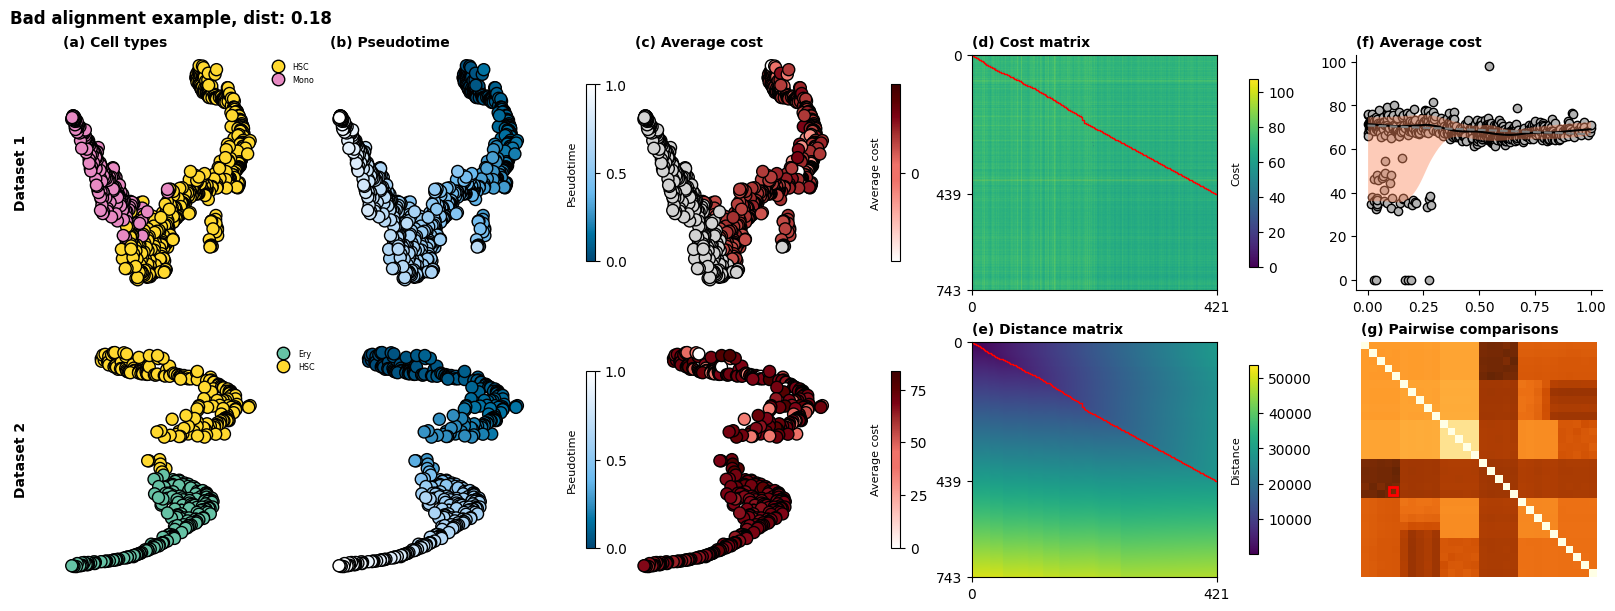

In [221]:
import matplotlib.pyplot as plt
colors = plt.colormaps["Set2"].colors + (plt.colormaps["Set3"].colors[9],)

fig, axes = plt.subplots(2, 8, figsize=(16, 6), gridspec_kw={'width_ratios': [8, 2, 8, 2, 8, 2, 10, 10]}, layout = 'constrained')
norm_dist_bad = dist_norm_np[bad_d1_id, bad_d2_id]
plt.suptitle(f"Bad alignment example, dist: {norm_dist_bad:0.2f}", x=0, horizontalalignment = "left", fontsize=12, fontweight='bold')

# CELL TYPES
plot_celltypes(bad_dataset1, [axes[0, 0], axes[0, 1]], colors = [colors[5], colors[3]])
axes[0, 0].set_title("(a) Cell types", fontsize=10, fontweight='bold', loc="left")
axes[0, 0].set_ylabel("Dataset 1", fontsize=10, fontweight='bold', rotation=90, labelpad=30, va='center')
plot_celltypes(bad_dataset2, [axes[1, 0], axes[1, 1]], colors = [colors[0], colors[5]])
axes[1, 0].set_ylabel("Dataset 2", fontsize=10, fontweight='bold', rotation=90, labelpad=30, va='center')

# PSEUDOTIME
plot_pseudotime(bad_dataset1, [axes[0, 2], axes[0, 3]], "Pseudotime", ticks = [0, 0.5, 1], label = "Pseudotime", labelx = 0.75, labely = 0.5)
axes[0, 2].set_title("(b) Pseudotime", fontsize=10, fontweight='bold', loc="left")
# axes[0, 2].set_yticks([])
plot_pseudotime(bad_dataset2, [axes[1, 2], axes[1, 3]], "Pseudotime", ticks = [0, 0.5, 1], label = "Pseudotime", labelx = 0.75, labely = 0.5)

# AVERAGE COST
red_tints = ['#EF7269', '#F78F85', '#FCACA2', '#FFC7C0', '#FFE3DF', '#FFFFFF'][::-1]
red_shades = ['#EF7269', '#C8504B', '#A22E2E', '#7D0214', '#5A0000', '#3E0000']
red_colors = red_tints + red_shades
plot_pseudotime(reference, [axes[0, 4], axes[0, 5]], "Average cost", labels=reference.obs["dtw_part_avg_cost"].values, colors=red_colors, ticks=[0, 25, 50, 75, 100], label = "Average cost", labelx = 0.75, labely = 0.5)
axes[0, 4].set_title("(c) Average cost", fontsize=10, fontweight='bold', loc="left")
plot_pseudotime(bad_dataset2, [axes[1, 4], axes[1, 5]], "Average cost", labels=bad_dataset2.obs["dtw_avg_cost"].values, colors=red_colors, ticks=[0, 25, 50, 75, 100], label = "Average cost", labelx = 0.75, labely = 0.5)

# COST MATRICES
plot_matrix(reference.obsm["dtw_part_cost"], [axes[0, 6]], [0, reference.obsm["dtw_part_cost"].shape[1]-1], [0, 439, reference.obsm["dtw_part_cost"].shape[0]-1], reference.obs["dtw_part_path"], query.obs["dtw_part_path"])
# dynchro.pl.plot_cost_matrix(reference.obsm["dtw_part_cost"], reference=reference, query=query, plot_paths=True, ax=axes[0, 6], dtw_key="dtw_part")
# get rid of title
axes[0, 6].title.set_text("")
axes[0, 6].set_title("(d) Cost matrix", fontsize=10, fontweight='bold', loc="left")
# dynchro.pl.plot_distance_matrix(reference.obsm["dtw_part_D"], reference=reference, query=query, plot_paths=True, ax=axes[1, 6], dtw_key="dtw_part")
plot_matrix(reference.obsm["dtw_part_D"], [axes[1, 6]], [0, reference.obsm["dtw_part_D"].shape[1]-1], [0, 439, reference.obsm["dtw_part_D"].shape[0]-1], reference.obs["dtw_part_path"], query.obs["dtw_part_path"])
axes[0, 6].text(455, 371, "Cost", rotation = 90, horizontalalignment='center', verticalalignment='center', fontsize=8)

axes[1, 6].title.set_text("")
axes[1, 6].set_title("(e) Distance matrix", fontsize=10, fontweight='bold', loc="left")
axes[1, 6].text(455, 371, "Distance", rotation = 90, horizontalalignment='center', verticalalignment='center', fontsize=8)


# AVG COST
plot_avg_cost(lowess_bad1, "Average cost", colors[7], axes[0, 7], removedspines=['top', 'right'])
axes[0, 7].spines[['top', 'right']].set_visible(False)
axes[0, 7].set_title("(f) Average cost", fontsize=10, fontweight='bold', loc="left")

# HEATMAP
axes[1, 7].axis('off')
plot_heatmap(dist_norm, axes[1,7], bad_d1_id, bad_d2_id)
axes[1, 7].set_title("(g) Pairwise comparisons", fontsize=10, fontweight='bold', loc="left")

# SAVE FIGURE
plt.savefig("figures/large_scale_bad_figure.png", dpi=300, bbox_inches='tight')
plt.savefig("figures/large_scale_bad_figure.pdf", dpi=300, bbox_inches='tight')
plt.show()

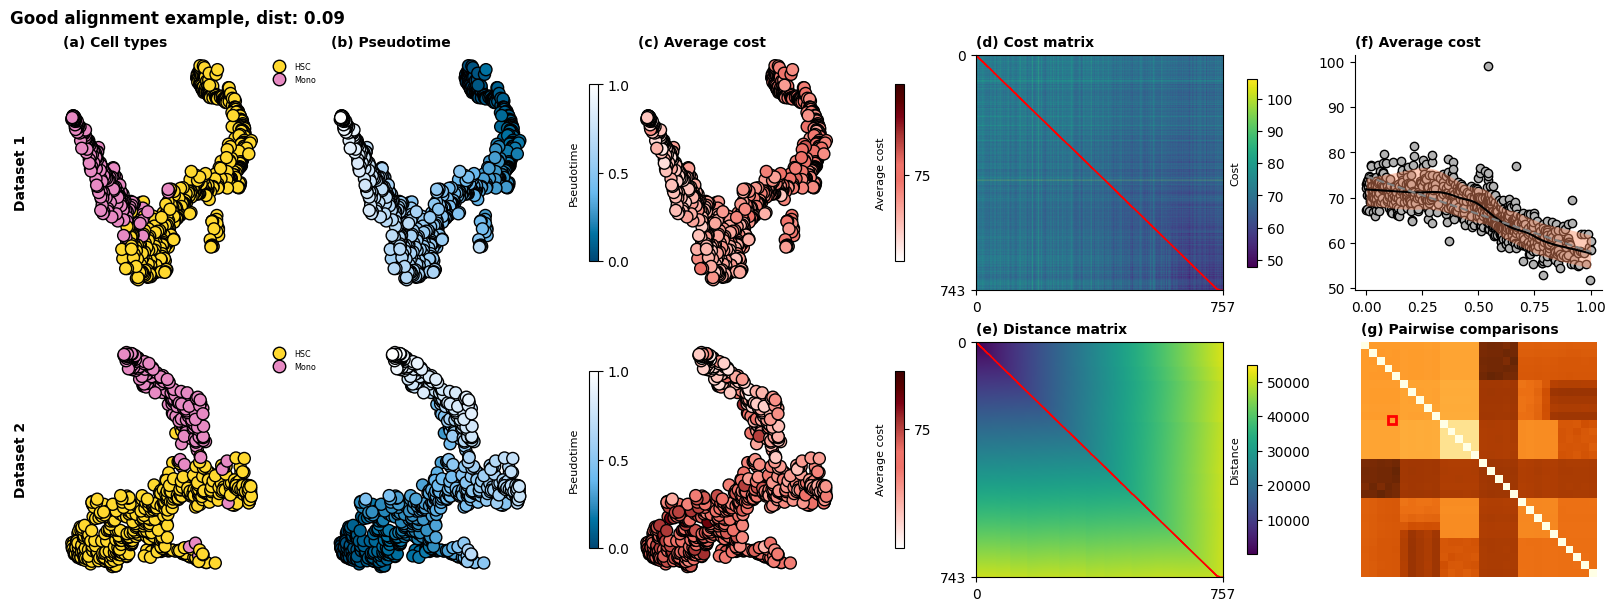

In [222]:
fig, axes = plt.subplots(2, 8, figsize=(16, 6), gridspec_kw={'width_ratios': [8, 2, 8, 2, 8, 2, 10, 10]}, layout='constrained')
norm_dist_good = dist_norm_np[good_d1_id, good_d2_id]
plt.suptitle(f"Good alignment example, dist: {norm_dist_good:0.2f}", x = 0, horizontalalignment='left', fontsize=12, fontweight='bold')

plot_celltypes(good_dataset1, [axes[0, 0], axes[0, 1]], colors = [colors[5], colors[3]])
axes[0, 0].set_title("(a) Cell types", fontsize=10, fontweight='bold', loc="left")
axes[0, 0].set_ylabel("Dataset 1", fontsize=10, fontweight='bold', rotation=90, labelpad=30, va='center')
plot_celltypes(good_dataset2, [axes[1, 0], axes[1, 1]], colors = [colors[5], colors[3]])
axes[1, 0].set_ylabel("Dataset 2", fontsize=10, fontweight='bold', rotation=90, labelpad=30, va='center')

plot_pseudotime(good_dataset1, [axes[0, 2], axes[0, 3]], "Pseudotime", ticks = [0, 0.5, 1], label = "Pseudotime", labelx = 0.75, labely = 0.5)
axes[0, 2].set_title("(b) Pseudotime", fontsize=10, fontweight='bold', loc="left")
plot_pseudotime(good_dataset2, [axes[1, 2], axes[1, 3]], "Pseudotime", ticks = [0, 0.5, 1], label = "Pseudotime", labelx = 0.75, labely = 0.5)

red_tints = ['#EF7269', '#F78F85', '#FCACA2', '#FFC7C0', '#FFE3DF', '#FFFFFF'][::-1]
red_shades = ['#EF7269', '#C8504B', '#A22E2E', '#7D0214', '#5A0000', '#3E0000']

red_colors = red_tints + red_shades

plot_pseudotime(good_dataset1, [axes[0, 4], axes[0, 5]], "Average cost", labels=good_dataset1.obs["dtw_avg_cost"].values, colors=red_colors, ticks=[0, 25, 50, 75, 100], label = "Average cost", labelx = 0.75, labely = 0.5)
axes[0, 4].set_title("(c) Average cost", fontsize=10, fontweight='bold', loc="left")
plot_pseudotime(good_dataset2, [axes[1, 4], axes[1, 5]], "Average cost", labels=good_dataset2.obs["dtw_avg_cost"].values, colors=red_colors, ticks=[0, 25, 50, 75, 100], label = "Average cost", labelx = 0.75, labely = 0.5)


plot_matrix(good_dataset1.obsm["dtw_cost"], [axes[0, 6]], [0, good_dataset1.obsm["dtw_cost"].shape[1]-1], [0, good_dataset1.obsm["dtw_cost"].shape[0]-1], good_dataset1.obs["dtw_path"], good_dataset2.obs["dtw_path"])
# dynchro.pl.plot_cost_matrix(good_dataset1.obsm["dtw_cost"], reference=good_dataset1, query=good_dataset2, plot_paths=True, ax=axes[0, 6])
axes[0, 6].title.set_text("")
axes[0, 6].set_title("(d) Cost matrix", fontsize=10, fontweight='bold', loc="left")
# dynchro.pl.plot_distance_matrix(good_dataset1.obsm["dtw_D"], reference=good_dataset1, query=good_dataset2, plot_paths=True, ax=axes[1, 6])
plot_matrix(good_dataset1.obsm["dtw_D"], [axes[1, 6]], [0, good_dataset1.obsm["dtw_D"].shape[1]-1], [0, good_dataset1.obsm["dtw_D"].shape[0]-1], good_dataset1.obs["dtw_path"], good_dataset2.obs["dtw_path"])
axes[0, 6].text(795, 371, "Cost", rotation = 90, horizontalalignment='center', verticalalignment='center', fontsize=8)

axes[1, 6].title.set_text("")
axes[1, 6].set_title("(e) Distance matrix", fontsize=10, fontweight='bold', loc="left")
axes[1, 6].text(795, 371, "Distance", rotation = 90, horizontalalignment='center', verticalalignment='center', fontsize=8)

plot_avg_cost(lowess_good1, "Average cost", colors[7], axes[0, 7], removedspines=['top', 'right'])
axes[0, 7].spines[['top', 'right']].set_visible(False)
axes[0, 7].set_title("(f) Average cost", fontsize=10, fontweight='bold', loc="left")

axes[1, 7].axis('off')
plot_heatmap(dist_norm, axes[1,7], good_d1_id, good_d2_id)
axes[1, 7].set_title("(g) Pairwise comparisons", fontsize=10, fontweight='bold', loc="left")

plt.savefig("figures/large_scale_good_figure.png", dpi=300, bbox_inches='tight')
plt.savefig("figures/large_scale_figure.pdf", dpi=300, bbox_inches='tight')

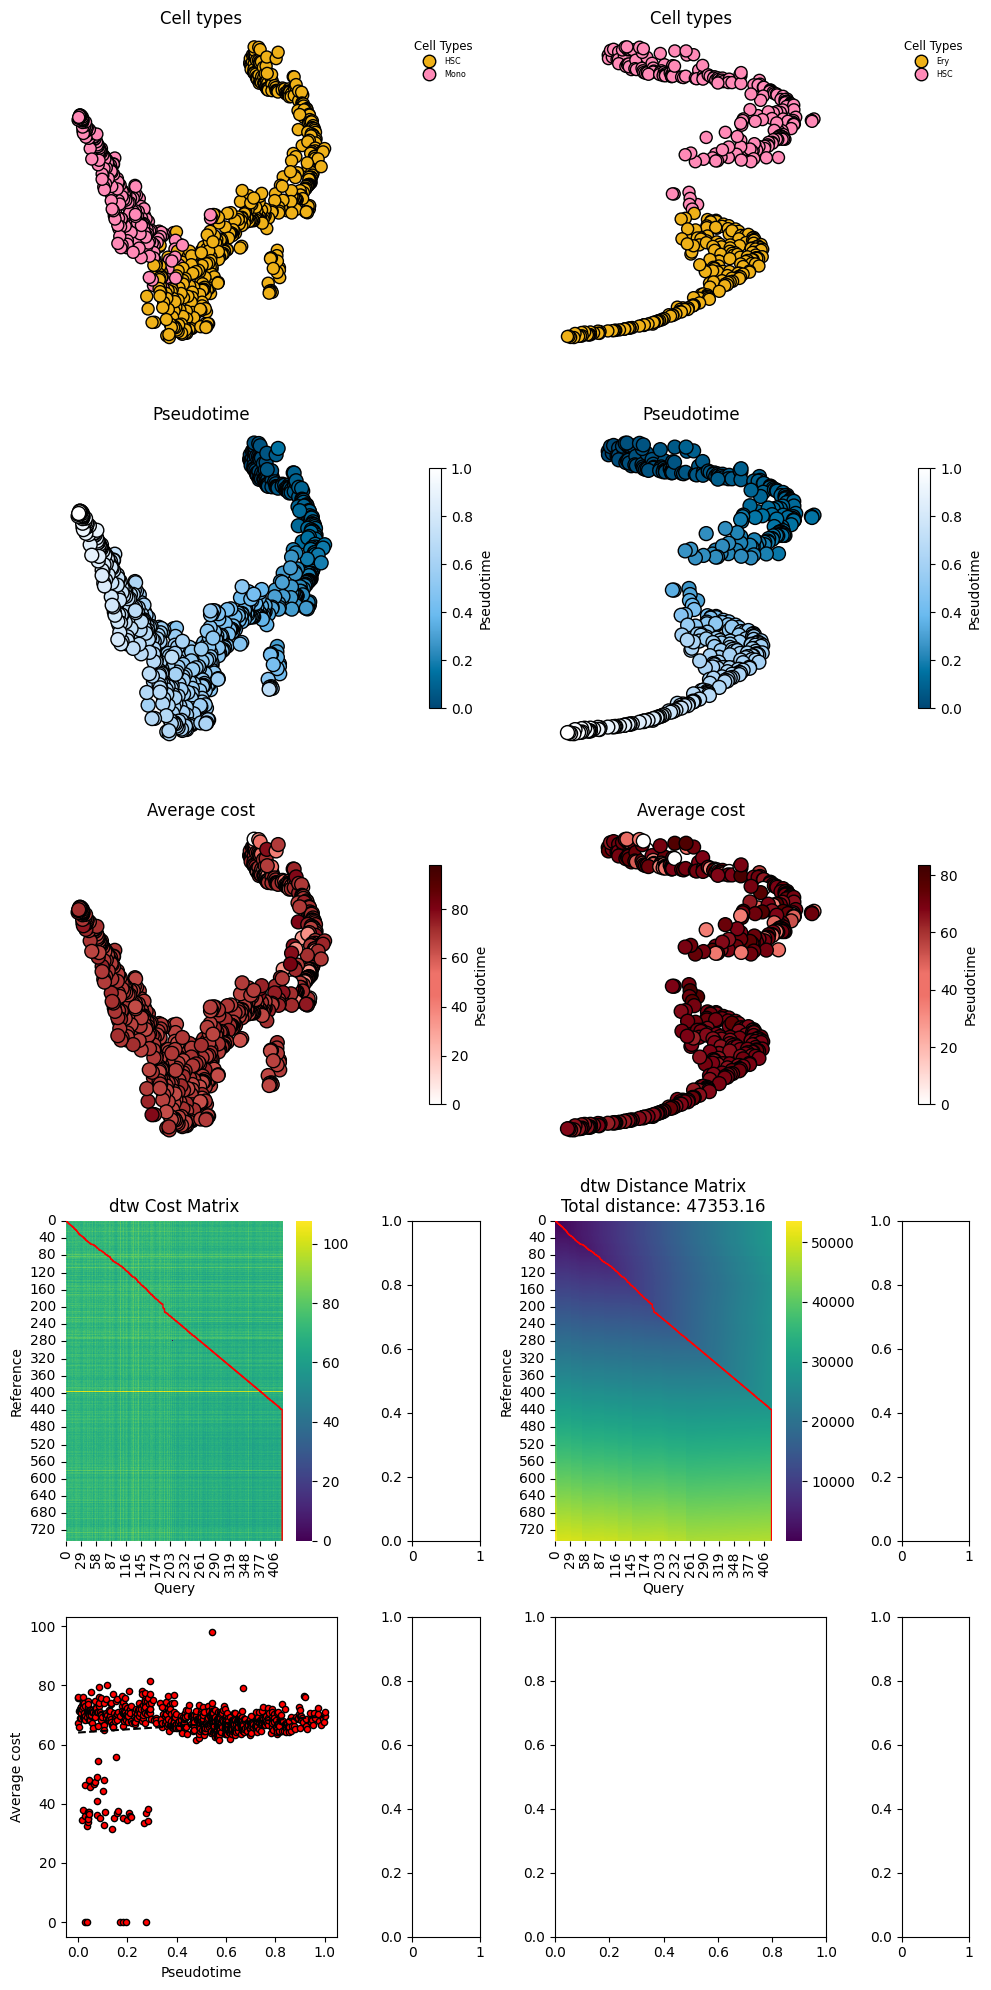

In [164]:
fig, axes = plt.subplots(5, 4, figsize=(10, 20), gridspec_kw={'width_ratios': [8, 2, 8, 2]})
plot_celltypes(bad_dataset1, [axes[0, 0], axes[0, 1]])
plot_celltypes(bad_dataset2, [axes[0, 2], axes[0, 3]])

plot_pseudotime(bad_dataset1, [axes[1, 0], axes[1, 1]], "Pseudotime")
plot_pseudotime(bad_dataset2, [axes[1, 2], axes[1, 3]], "Pseudotime")

red_tints = ['#EF7269', '#F78F85', '#FCACA2', '#FFC7C0', '#FFE3DF', '#FFFFFF'][::-1]
red_shades = ['#EF7269', '#C8504B', '#A22E2E', '#7D0214', '#5A0000', '#3E0000']

red_colors = red_tints + red_shades

plot_pseudotime(bad_dataset1, [axes[2, 0], axes[2, 1]], "Average cost", labels=bad_dataset1.obs["dtw_avg_cost"].values, colors=red_colors)
plot_pseudotime(bad_dataset2, [axes[2, 2], axes[2, 3]], "Average cost", labels=bad_dataset2.obs["dtw_avg_cost"].values, colors=red_colors)

dynchro.pl.plot_cost_matrix(bad_dataset1.obsm["dtw_cost"], reference=bad_dataset1, query=bad_dataset2, plot_paths=True, ax=axes[3, 0])
dynchro.pl.plot_distance_matrix(bad_dataset1.obsm["dtw_D"], reference=bad_dataset1, query=bad_dataset2, plot_paths=True, ax=axes[3, 2])

plot_avg_cost(bad_dataset1.obs["dtw_avg_cost"].values, bad_dataset1.obs["pseudotime"].values, axes[4, 0], color='red')  
# plot_avg_cost(bad_dataset2.obs["dtw_avg_cost"].values, bad_dataset2.obs["pseudotime"].values, axes[1, 7], color='red')

plt.tight_layout()

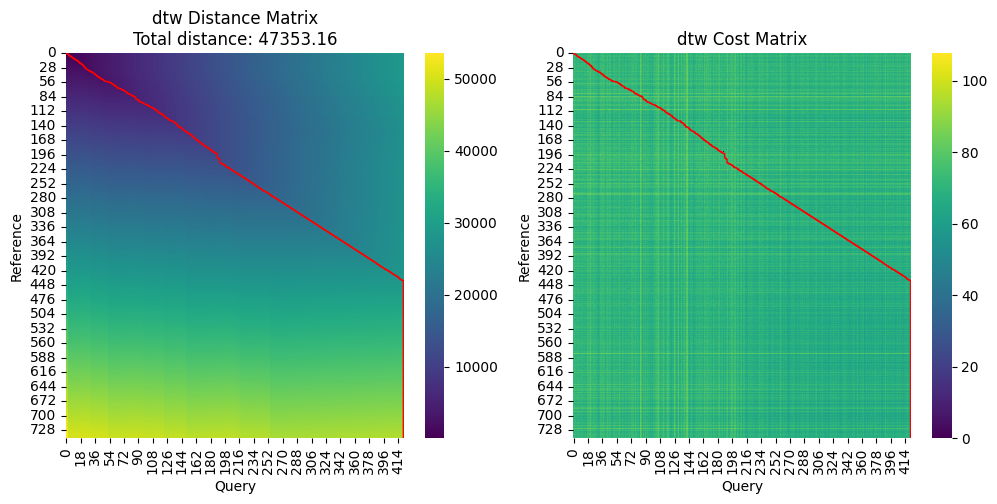

In [146]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

dynchro.pl.plot_cost_matrix(bad_dataset1.obsm["dtw_cost"], reference=bad_dataset1, query=bad_dataset2, plot_paths=True, ax=axes[1])
dynchro.pl.plot_distance_matrix(bad_dataset1.obsm["dtw_D"], reference=bad_dataset1, query=bad_dataset2, plot_paths=True, ax=axes[0])

plt.show()

In [142]:
axes

array([<Axes: title={'center': 'dtw Cost Matrix'}, xlabel='Query', ylabel='Reference'>,
       <Axes: title={'center': 'dtw Distance Matrix\nTotal distance: 47353.16'}, xlabel='Query', ylabel='Reference'>],
      dtype=object)

In [131]:
bad_dataset1.obsm

AxisArrays with keys: MAGIC_imputed_data, X_tsne, palantir_branch_probs, tsne, dtw_cost, dtw_D

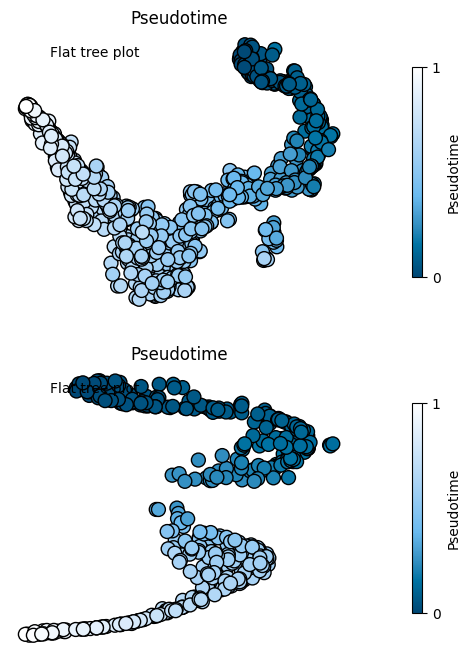

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(6, 8), gridspec_kw={'width_ratios': [8, 2]})
plot_pseudotime(bad_dataset1, [axes[0, 0], axes[0, 1]], "Pseudotime")
plot_pseudotime(bad_dataset2, [axes[1, 0], axes[1, 1]], "Pseudotime")